In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, LSTM, Embedding, GRU, add, concatenate, Reshape
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

2024-04-27 12:38:00.222031: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-27 12:38:00.222120: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-27 12:38:00.354087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
image_path = '../input/flickr8k/Images'
data = pd.read_csv("../input/flickr8k/captions.txt")
data.head()


,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [ ]:
from sklearn.model_selection import train_test_split

data_shuffled = data.sample(frac=1, random_state=42).reset_index(drop=True)

train_ratio = 0.85
train_data, test_data = train_test_split(data_shuffled, train_size=train_ratio, random_state=42)

tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_shuffled['caption'])
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in data_shuffled['caption'])

train_sequences = tokenizer.texts_to_sequences(train_data['caption'])
test_sequences = tokenizer.texts_to_sequences(test_data['caption'])

train_images = train_data['image'].unique().tolist()
test_images = test_data['image'].unique().tolist()

train_captions = train_data['caption']
test_captions = test_data['caption']

print(tokenizer.texts_to_sequences([train_captions.iloc[0]]))


[1, 18, 315, 63, 195, 116, 2]

In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1714221522.935746     103 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [12:31<00:00, 10.77it/s]


In [ ]:
import numpy as np
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

class CustomDataGenerator(Sequence):

    def __init__(self, data_df, image_col, caption_col, batch_size, img_directory,
                 tokenizer, vocab_size, max_caption_length, img_features, shuffle=True):
        self.data_df = data_df.copy()
        self.image_col = image_col
        self.caption_col = caption_col
        self.img_directory = img_directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_caption_length = max_caption_length
        self.img_features = img_features
        self.shuffle = shuffle
        self.data_size = len(self.data_df)

    def on_epoch_end(self):
        if self.shuffle:
            self.data_df = self.data_df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.data_size // self.batch_size

    def __get_data(self, batch):
        X1, X2, y = [], [], []

        images = batch[self.image_col].tolist()

        for image in images:
            feature = self.img_features[image][0]

            captions = batch.loc[batch[self.image_col] == image, self.caption_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_caption_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        return np.array(X1), np.array(X2), np.array(y)


In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = GRU(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')
caption_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 1920)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │    491,776 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 256)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 34, 256)   │  2,172,160 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 35, 256)   │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 256)       │    394,752 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 8485)      │  1,094,565 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,186,149 (15.97 MB)

 Trainable params: 4,186,149 (15.97 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
train_data_generator = CustomDataGenerator(data_df=train_data,
                                           image_col='image',
                                           caption_col='caption',
                                           batch_size=64,
                                           img_directory=image_directory,
                                           tokenizer=tokenizer,
                                           vocab_size=vocab_size,
                                           max_caption_length=max_length,
                                           img_features=image_features)

validation_data_generator = CustomDataGenerator(data_df=test_data,
                                                image_col='image',
                                                caption_col='caption',
                                                batch_size=64,
                                                img_directory=image_directory,
                                                tokenizer=tokenizer,
                                                vocab_size=vocab_size,
                                                max_caption_length=max_length,
                                                img_features=image_features)


In [ ]:
model_name = "model.h5.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(
        train_data_generator,
        epochs=20,
        validation_data=validation_data_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - loss: 5.5762
Epoch 1: val_loss improved from inf to 4.06861, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 314s 572ms/step - loss: 5.5750 - val_loss: 4.0686 - learning_rate: 0.0010
Epoch 2/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 4.0859
Epoch 2: val_loss improved from 4.06861 to 3.80155, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 81s 149ms/step - loss: 4.0857 - val_loss: 3.8015 - learning_rate: 0.0010
Epoch 3/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 3.8138
Epoch 3: val_loss improved from 3.80155 to 3.69714, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 83s 153ms/step - loss: 3.8138 - val_loss: 3.6971 - learning_rate: 0.0010
Epoch 4/20
536/537 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 3.6535
Epoch 4: val_loss improved from 3.69714 to 3.63301, saving model to model.h5.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 79s 145ms/step - loss: 3.6535 - val_loss: 3.6330 - learning_rate: 0.001

In [ ]:
# Evaluate the model on the validation data
loss = caption_model.evaluate(validation_generator, verbose=1)

# Print the evaluation results
print("Validation Loss:", loss)


94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 3.6163
Validation Loss: 3.5931625366210938


In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def generate_caption(model, image_feature, tokenizer, max_length, features):

    current_text = "startseq"
    for _ in range(max_length):
        sequence = tokenizer.texts_to_sequences([current_text])[0]
        sequence = pad_sequences([sequence], max_length)

        prediction = model.predict([image_feature, sequence])
        predicted_word_index = np.argmax(prediction)

        predicted_word = index_to_word(predicted_word_index, tokenizer)

        if predicted_word is None:
            break

        current_text += " " + predicted_word

        if predicted_word == 'endseq':
            break

    return current_text


In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)


In [ ]:
for idx, sample in samples.iterrows():
    img_path = os.path.join(image_path, sample['image'])
    img = load_and_preprocess_image(img_path)

    generated_caption = generate_caption(caption_model, sample['image'], tokenizer, max_length, features)

    samples.loc[idx, 'predicted_caption'] = generated_caption


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

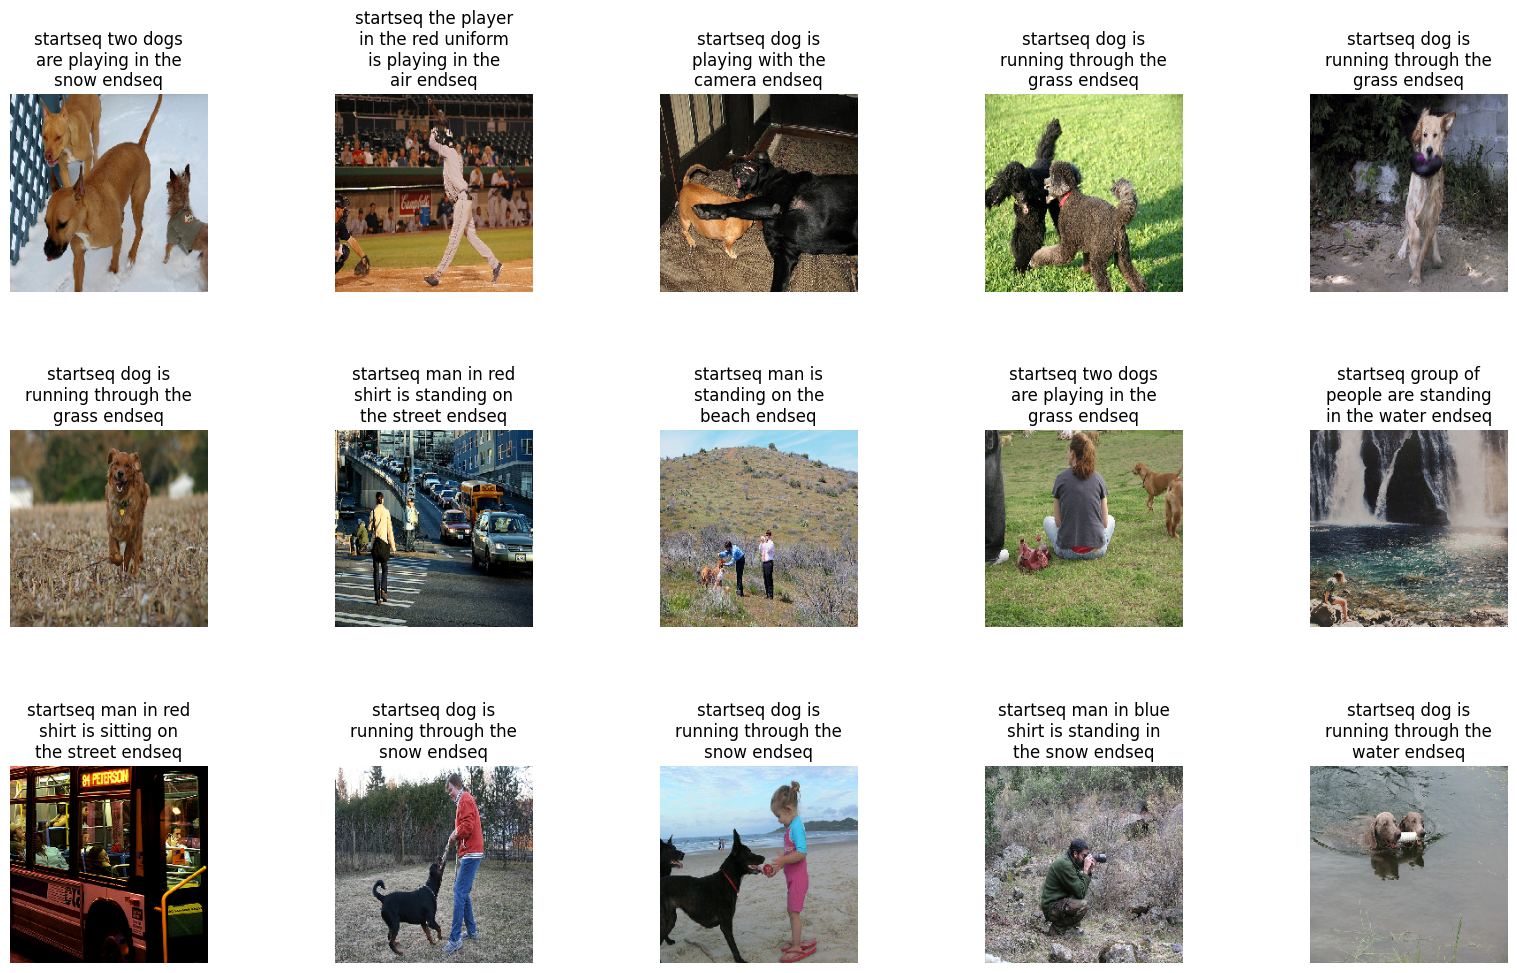

In [ ]:
display_images(samples)
